In [2]:
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

from FinancialMachineLearning.feature_importance.importance import (
    mean_decrease_impurity,
    mean_decrease_accuracy,
    single_feature_importance,
    plot_feature_importance
)
from FinancialMachineLearning.feature_importance.orthogonal import get_orthogonal_features
from FinancialMachineLearning.machine_learning.cross_validation import PurgedKFold, ml_cross_val_score
from FinancialMachineLearning.multiprocess.multiprocess import process_jobs

/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/multiprocess/fast_ewma.py:5: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit((float64[:], int64), nopython = False, nogil = True)


In [6]:
from sklearn.datasets import make_classification

def get_test_data(n_features = 40, 
                  n_informative = 10, 
                  n_redundant = 10, 
                  n_samples = 10000):  
    trnsX, cont = make_classification(n_samples=n_samples, n_features=n_features, n_informative=n_informative, n_redundant=n_redundant, random_state=0, shuffle=False)
    start = pd.datetime.today()
    end = start + pd.Timedelta(minutes=n_samples-1)
    df0 = pd.date_range(start=start, end=end, freq='T')
    trnsX = pd.DataFrame(trnsX, index=df0)
    cont = pd.Series(cont, index=df0).to_frame('bin')
    df0 = ['I_%s' % i for i in range(n_informative)] + ['R_%s' % i for i in range(n_redundant)]
    df0 += ['N_%s' % i for i in range(n_features - len(df0))]
    trnsX.columns = df0
    cont['w'] = 1.0 / cont.shape[0]
    cont['t1'] = pd.Series(cont.index, index=cont.index)
    return trnsX, cont

In [12]:
def feature_importances(X, cont, method, allow_masking_effects=False, n_splits=10):
    max_features = None if allow_masking_effects else 1
    clf = DecisionTreeClassifier(
        criterion='entropy', max_features=max_features, class_weight='balanced', min_weight_fraction_leaf=0.0
    )
    clf = BaggingClassifier(
        base_estimator=clf, n_estimators=1000, max_features=1.0, max_samples=1.0, oob_score=True, n_jobs=-1
    )
    fit = clf.fit(X, cont['bin'])
    oob_score = fit.oob_score_

    cv_gen = PurgedKFold(n_splits=n_splits, samples_info_sets=cont['t1'])
    oos_score = ml_cross_val_score(clf, X, cont['bin'], cv_gen=cv_gen, scoring=accuracy_score).mean()

    if method == 'MDI':
        imp = mean_decrease_impurity(fit, X.columns)
    elif method == 'MDA':
        imp = mean_decrease_accuracy(clf, X, cont['bin'], cv_gen, scoring=accuracy_score)
    elif method == 'SFI':
        imp = single_feature_importance(clf, X, cont['bin'], cv_gen, scoring=accuracy_score)
    
    return imp, oob_score, oos_score


def test_data_func(X, cont, run='', allow_masking_effects=False, methods=['MDI', 'MDA', 'SFI']):
    for method in methods:
        feature_imp, oob_score, oos_score = feature_importances(X, cont, method, allow_masking_effects)
        plot_feature_importance(
            feature_imp, oob_score=oob_score, oos_score=oos_score,
            save_fig = False
        )


#### generate Test Data Set 

In [8]:
X, cont = get_test_data(n_features=12, n_informative=4, n_redundant=4, n_samples=5000)
X.head()

/var/folders/1q/pl9tj55n57s9jg28npxw61n80000gn/T/ipykernel_32743/2422749990.py:8: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start = pd.datetime.today()


,I_0,I_1,I_2,I_3,R_0,R_1,R_2,R_3,N_0,N_1,N_2,N_3
2023-09-17 23:47:52.908443,-3.941539,-1.955124,-1.247683,-0.665536,2.870924,0.706670,-0.144982,-1.498281,-0.229430,0.177231,0.648948,-0.818646
2023-09-17 23:48:52.908443,-2.882175,-1.822702,-0.568862,0.103451,2.196651,0.966482,-0.527894,-1.100332,0.130209,-0.831310,1.484291,0.320911
2023-09-17 23:49:52.908443,-1.897824,-0.659752,-0.575968,1.432049,1.647345,0.800773,-0.995133,-1.899108,-1.667659,-0.005389,2.347850,0.202494
2023-09-17 23:50:52.908443,-2.574587,1.990887,0.383741,3.980372,3.637930,0.773705,-1.803899,-6.490407,0.105738,1.093880,-0.037027,-1.414238
2023-09-17 23:51:52.908443,-1.885823,-2.601728,-1.325420,-0.736274,0.621126,0.755418,-0.237697,1.156626,-1.178807,0.069023,0.454516,-0.522534


#### PCA transformation

PCA : orthogonal 

In [9]:
Xdot = pd.DataFrame(get_orthogonal_features(X), index = X.index).add_prefix("PCA_")
Xdot.head()

,PCA_0,PCA_1,PCA_2,PCA_3,PCA_4,PCA_5,PCA_6
2023-09-17 23:47:52.908443,2.065379,0.146105,-1.182983,0.134590,0.530868,0.363318,-0.852387
2023-09-17 23:48:52.908443,1.839769,0.822382,-0.949730,1.217152,-0.766848,0.026661,-1.015070
2023-09-17 23:49:52.908443,1.955510,1.095325,0.280685,2.428007,0.794605,0.732763,-1.020887
2023-09-17 23:50:52.908443,4.569843,1.217288,1.651004,-1.110274,1.290850,0.047355,-0.666502
2023-09-17 23:51:52.908443,0.234743,0.652217,-1.114901,0.621042,0.784154,0.946805,-0.232960


/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

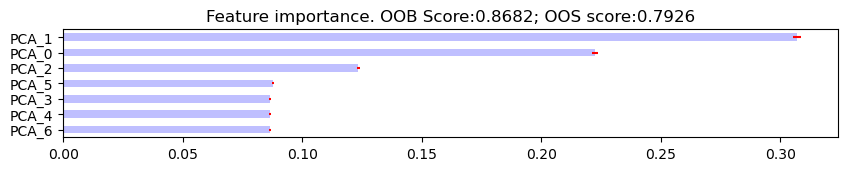

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

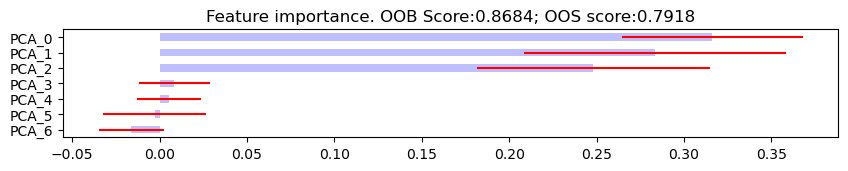

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

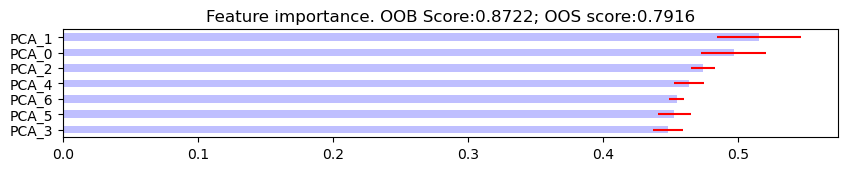

In [13]:
test_data_func(Xdot, cont)

In [14]:
Xdotdot = pd.concat([X, Xdot], axis=1)

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

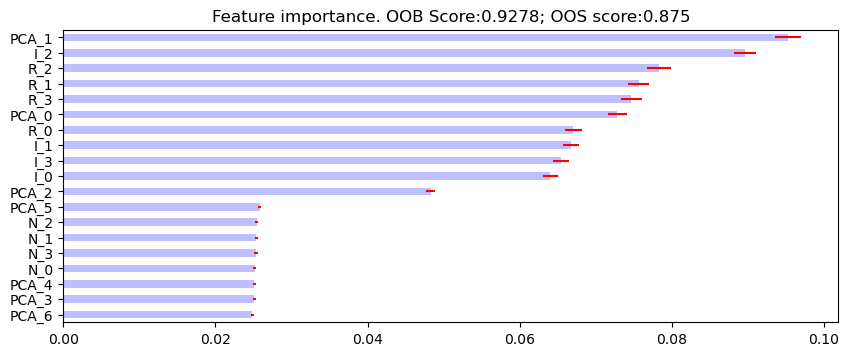

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

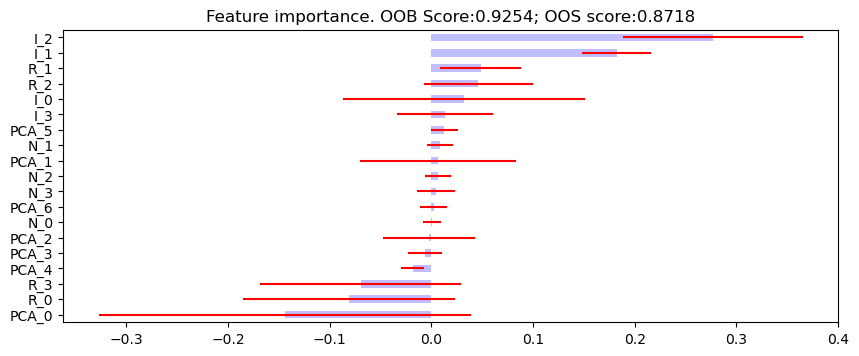

/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in test_times.iteritems():
/Users/junghunlee/anaconda3/envs/FinancialMachineLearning/lib/python3.10/site-packages/sklearn/ensemble/_base.py:156: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(
/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning/FinancialMachineLearning/machine_learning/cross_validation.py:13: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for start_ix, end_ix in 

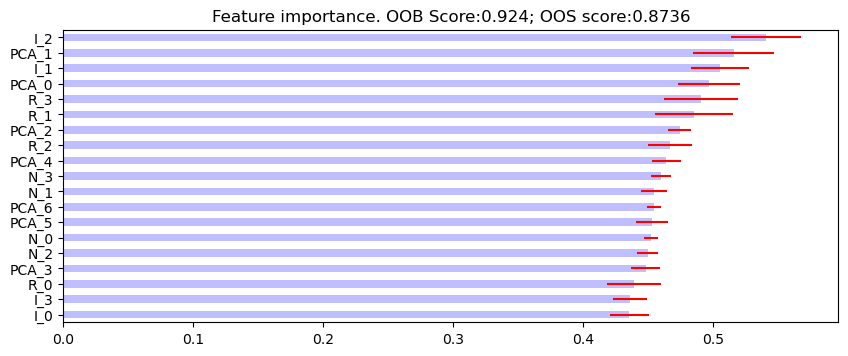

In [15]:
test_data_func(Xdotdot, cont)

In [16]:
import os
os.chdir('..')
os.chdir('..')
os.getcwd()

'/Users/junghunlee/Desktop/Pycharm/FinancialMachineLearning'

In [18]:
cont

,bin,w,t1
2023-09-17 23:47:52.908443,0,0.0002,2023-09-17 23:47:52.908443
2023-09-17 23:48:52.908443,0,0.0002,2023-09-17 23:48:52.908443
2023-09-17 23:49:52.908443,0,0.0002,2023-09-17 23:49:52.908443
2023-09-17 23:50:52.908443,0,0.0002,2023-09-17 23:50:52.908443
2023-09-17 23:51:52.908443,0,0.0002,2023-09-17 23:51:52.908443
...,...,...,...
2023-09-21 11:02:52.908443,1,0.0002,2023-09-21 11:02:52.908443
2023-09-21 11:03:52.908443,1,0.0002,2023-09-21 11:03:52.908443
2023-09-21 11:04:52.908443,1,0.0002,2023-09-21 11:04:52.908443
2023-09-21 11:05:52.908443,1,0.0002,2023-09-21 11:05:52.908443


In [17]:
matrix = pd.read_csv('./Data/labeled_vertical10.csv', index_col = 0)
matrix

,price,return,fracdiff,volatility,concurrency,uniqueness,side,label
2010-04-29 10:26:57,58.2801,-0.011465,10.476812,0.010964,20.0,0.074445,-1.0,1
2010-04-29 11:09:15,58.3600,-0.012819,10.507715,0.011247,7.0,0.075186,-1.0,1
2010-04-29 11:34:28,58.4100,-0.013664,10.488812,0.011638,5.0,0.067364,-1.0,1
2010-04-29 11:44:01,58.4900,-0.012306,10.540226,0.011979,6.0,0.066014,-1.0,1
2010-04-29 12:00:06,58.4498,-0.014335,10.465450,0.012262,7.0,0.059366,-1.0,1
...,...,...,...,...,...,...,...,...
2023-05-08 15:16:20,152.1563,-0.010951,26.030479,0.010701,46.0,0.020092,-1.0,1
2023-05-08 15:16:37,152.0900,-0.011112,25.963539,0.010595,47.0,0.022152,-1.0,1
2023-05-08 15:36:39,152.0701,-0.010391,25.952489,0.010387,48.0,0.020022,-1.0,1
2023-05-08 15:47:11,152.1800,-0.011105,26.065165,0.010283,49.0,0.020007,-1.0,1


In [ ]:
X_mat = matrix.iloc[:, [0,2,3,4]]